# Getting started with `aehmc` and `aeppl`

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm

import aesara
import aesara.tensor as at
from aesara.tensor.random.utils import RandomStream
from aeppl.transforms import TransformValuesOpt, LogTransform

from aeppl import joint_logprob

import aehmc.hmc as hmc
import aehmc.nuts as nuts
from aehmc.utils import RaveledParamsMap

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
NUM_INTEGRATION_STEPS = 1024
STEP_SIZE = 5e-5
PATH_LENGTH = STEP_SIZE * NUM_INTEGRATION_STEPS

NUM_SAMPLES = 1_000
BURNIN = 100

## A simple linear regression

We consider a simple one-dimensional regression problem. To make it a little challenging, we create a dataset with 10,000 points:

In [3]:
X_val = np.random.normal(0, 1, size=(10_000,))
y_val = 3 * X_val + np.random.normal(0,1)

### PyMC3 implementation

In [4]:
with pm.Model() as pymc3_model:
    weights = pm.Normal("weights", mu=0, sigma=1)
    noise = pm.Gamma("noise", alpha=2, beta=1)
    y_observed = pm.Normal(
        "y_observed",
        mu=X_val @ weights,
        sigma=noise,
        observed=y_val,
    )

### Aeppl implementation

We can implement the posterior log-probability density function of this model directly using `aesara` and `aeppl`:

In [5]:
X_at = at.as_tensor(X_val)

N_rv = at.random.gamma(2.0, 1.0, name="N")
W_rv = at.random.normal(0, 1.0, name="W")
Y_rv = at.random.normal(X_at.dot(W_rv), N_rv, name="Y")


# `aehmc` kernels take a vector as an input. We use a `RaveledParamsMap` to unravel this vector
# and retrieve ta values for `W_rv` and `Y_rv`.
rp_map = RaveledParamsMap((W_rv, N_rv))


def aeppl_logprob(q):
    uraveled_params = rp_map.unravel_params(q)
    N_vv = uraveled_params[N_rv]
    W_vv = uraveled_params[W_rv]
    
    # The gamma distribution's support is the positive real numbers; algorithms like HMC however prefer to 
    # with parameters on the real line. We thus apply a log transform to `N_vv`. PyMC3 applies this 
    # transform automatically.
    transforms_op = TransformValuesOpt({N_vv: LogTransform()})

    logprob = joint_logprob({Y_rv: at.as_tensor(y_val), N_rv: N_vv, W_rv: W_vv}, extra_rewrites=transforms_op)
    return logprob

In [6]:
q = at.vector('q')

logprob_fn = aesara.function((q,), aeppl_logprob(q))
logprob_fn([3., np.log(10.)])

array(-32226.13316819)

We can check that the loglikelihood returns the same values as the logpdf produced by PyMC3:

In [7]:
pymc3_model.fastlogp({'weights':3, 'noise_log__': np.log(10)})

array(-32226.13316819)

### Sampling with aehmc's HMC algorithm

#### Build the HMC kernel

The `hmc.kernel` function returns, given the parameters of the HMC algorithm (a random seed, the potential, the step size, inverse mass matrix and number of integration steps) returns a "kernel" which given a chain state returns a graph that computes the next chain state:

In [8]:
srng = RandomStream(seed=1)
inverse_mass_matrix = at.as_tensor(np.array([1., 1.]))
kernel = hmc.kernel(srng, aeppl_logprob, STEP_SIZE, inverse_mass_matrix, NUM_INTEGRATION_STEPS)

Let us compile this graph into a function:

In [9]:
q = at.vector("q")
potential_energy = -aeppl_logprob(q)
potential_energy_grad = aesara.grad(potential_energy, wrt=q)

next_step = kernel(q, potential_energy, potential_energy_grad)
kernel_fn = aesara.function((q,), next_step)

Let's execute it for one position:

In [10]:
kernel_fn(np.array([3., np.log(.21)]))

[array([ 2.99529076, -1.58025722]),
 array(-6405.67623355),
 array([-1122.04138901,  9600.7272448 ])]

#### Build the trajectory

We can also build a graph that computes the entire trajectory given the initial position and a number of samples, using aesara `scan` construct:

In [11]:
def build_trajectory_generator(srng, kernel_generator, logprob_fn, num_samples):
    """Builds a function which, given an initial position, returns the full trajectory."""
    q = at.vector("q")
    potential_energy = -logprob_fn(q)
    potential_energy_grad = aesara.grad(potential_energy, wrt=q)

    step_size = at.scalar("step_size")
    inverse_mass_matrix = at.vector("inverse_mass_matrix")
    num_integration_steps = at.scalar("num_integration_steps", dtype="int32")

    kernel = kernel_generator(
        srng, logprob_fn, step_size, inverse_mass_matrix, num_integration_steps
    )

    trajectory, updates = aesara.scan(
        fn=kernel,
        outputs_info=[
            {"initial": q},
            {"initial": potential_energy},
            {"initial": potential_energy_grad},
        ],
        n_steps=num_samples,
    )
    trajectory_generator = aesara.function(
        (q, step_size, inverse_mass_matrix, num_integration_steps),
        trajectory,
        updates=updates,
    )

    return trajectory_generator

We can now compile the function that generates the chain and execute it:

In [12]:
%%time
trajectory_generator = build_trajectory_generator(
    srng, hmc.kernel, aeppl_logprob, num_samples=NUM_SAMPLES
)

initial_position = np.array([3., np.log(0.6)])
inverse_mass_matrix = np.array([1., 1.])
position, *_ = trajectory_generator(initial_position, STEP_SIZE, inverse_mass_matrix, NUM_INTEGRATION_STEPS)

CPU times: user 46.1 s, sys: 290 ms, total: 46.4 s
Wall time: 46.7 s


Let us quickly check that the chain sampled correctly:

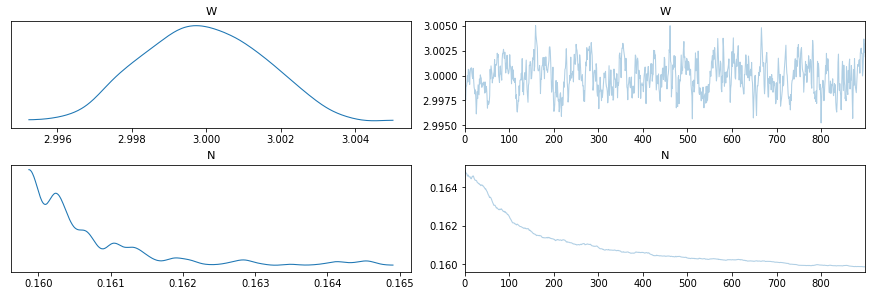

In [15]:
import arviz as az

aehmc_trace = az.from_dict(posterior={"W": position[BURNIN:, 0], "N": np.exp(position[BURNIN:, 1])})
az.plot_trace(aehmc_trace);

### Sampling with PyMC3

We are now ready to compare the performance of `aehmc`'s HMC kernel to that of PyMC3.

In [14]:
import time 

with pymc3_model:
    step = pm.step_methods.hmc.hmc.HamiltonianMC(
        [weights, noise],
        path_length=PATH_LENGTH,
        step_scale=STEP_SIZE,
        adapt_step_size=False,
    )
    
    # Set initial values
    weights.tag.test_value = initial_position[0]
    noise.tag.test_value = initial_position[1]
    
with pymc3_model:
    start = time.perf_counter()
    posterior = pm.sample(
        tune=0,
        draws=NUM_SAMPLES,
        step=[step],
        chains=1,
        cores=1,
        return_inferencedata=False,
        compute_convergence_checks=False
    )
    end = time.perf_counter()
    print(end - start)

Sequential sampling (1 chains in 1 job)
HamiltonianMC: [noise, weights]


Sampling 1 chain for 0 tune and 1_000 draw iterations (0 + 1_000 draws total) took 87 seconds.
The acceptance probability does not match the target. It is 0.9999889352443065, but should be close to 0.65. Try to increase the number of tuning steps.


87.74762003000069


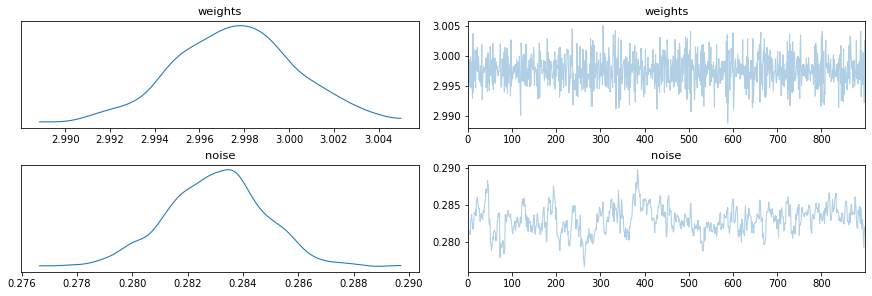

In [15]:
posterior_trace = az.from_pymc3(posterior[BURNIN:], model=pymc3_model)
az.plot_trace(posterior_trace);

## Logistic regression

### Load an prepare the data

In [16]:
raw_data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None,
    names=[
        "age",
        "workclass",
        "fnlwgt",
        "education-categorical",
        "educ",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "captial-gain",
        "capital-loss",
        "hours",
        "native-country",
        "income",
    ],
)

In [17]:
income = 1 * (raw_data['income'] == " >50K")[:500]

data = raw_data[["age", "educ", "hours"]][:500]
data["age"] = data["age"] / 10.0
data["age2"] = np.square(data["age"])
data["income"] = income

Y_val = income.values
X_val = data[["age", "age2","educ", "hours"]].values

In [18]:
data.income.value_counts()

0    387
1    113
Name: income, dtype: int64

### PyMC3 model implementation

In [20]:
with pm.Model() as pymc3_model:
    intercept = pm.Normal('intercept', 0, 1)
    age = pm.Normal('age', 0, 1)
    age2 = pm.Normal('age2', 0, 1)
    educ = pm.Normal('educ', 0, 1)
    hours = pm.Normal('hours', 0, 1)
    theta = pm.math.sigmoid(intercept + age * data['age'] + age2 * data['age2'] + educ * data['educ'] + hours * data['hours'])
    y = pm.Bernoulli('y', theta, observed=data['income'])


    #pm.glm.GLM.from_formula(
    #    "income ~ age + age2 + educ + hours", data, family=pm.glm.families.Binomial()
    #)
    step = pm.step_methods.NUTS([intercept, age, age2, educ, hours])
    trace = pm.sample(1000, tune=1000, step=step, init="adapt_diag", chains=1)

<ipython-input-20-6930925324ba>:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=1000, step=step, init="adapt_diag", chains=1)
Sequential sampling (1 chains in 1 job)
NUTS: [hours, educ, age2, age, intercept]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'age2'}>,
        <AxesSubplot:title={'center':'age2'}>],
       [<AxesSubplot:title={'center':'educ'}>,
        <AxesSubplot:title={'center':'educ'}>],
       [<AxesSubplot:title={'center':'hours'}>,
        <AxesSubplot:title={'center':'hours'}>]], dtype=object)

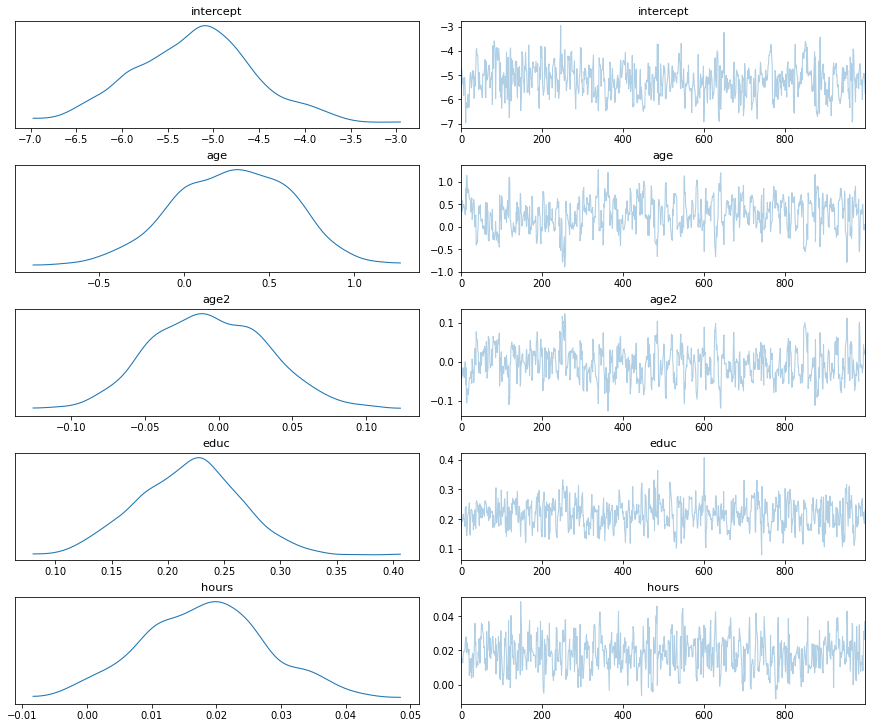

In [21]:
az.plot_trace(trace)

In [25]:
trace.get_sampler_stats('step_size_bar')

array([0.09292947, 0.09292947, 0.09292947, 0.09292947, 0.09292947,
       0.09292947, 0.09292947, 0.09292947, 0.09292947, 0.09292947,
       0.09292947, 0.09292947, 0.09292947, 0.09292947, 0.09292947,
       0.09292947, 0.09292947, 0.09292947, 0.09292947, 0.09292947,
       0.09292947, 0.09292947, 0.09292947, 0.09292947, 0.09292947,
       0.09292947, 0.09292947, 0.09292947, 0.09292947, 0.09292947,
       0.09292947, 0.09292947, 0.09292947, 0.09292947, 0.09292947,
       0.09292947, 0.09292947, 0.09292947, 0.09292947, 0.09292947,
       0.09292947, 0.09292947, 0.09292947, 0.09292947, 0.09292947,
       0.09292947, 0.09292947, 0.09292947, 0.09292947, 0.09292947,
       0.09292947, 0.09292947, 0.09292947, 0.09292947, 0.09292947,
       0.09292947, 0.09292947, 0.09292947, 0.09292947, 0.09292947,
       0.09292947, 0.09292947, 0.09292947, 0.09292947, 0.09292947,
       0.09292947, 0.09292947, 0.09292947, 0.09292947, 0.09292947,
       0.09292947, 0.09292947, 0.09292947, 0.09292947, 0.09292

In [54]:
pymc3_covariance = step.potential._var
pymc3_covariance

array([1.04407378e-04, 2.37760146e-03, 1.91769437e-03, 1.48259870e-01,
       4.76447789e-01])

### Aeppl model implementation

In [33]:
X_at = aet.as_tensor(X_val)
Y_at = aet.as_tensor(Y_val)

A_rv = aet.random.normal(0, 1, name='alpha')
B_rv = aet.random.normal(0, 1, size=(4,), name='beta')
P_rv = aet.sigmoid(A_rv + aet.dot(X_at, B_rv))
Y_rv = aet.random.bernoulli(P_rv)

rp_map = RaveledParamsMap((A_rv, B_rv))

def logistic_logprob(q):
    unraveled_params = rp_map.unravel_params(q)
    A_vv = unraveled_params[A_rv]
    B_vv = unraveled_params[B_rv]
    logprob = joint_logprob(Y_rv, {Y_rv: Y_at, A_rv: A_vv, B_rv: B_vv})
    return logprob

### Sampling with aehmc's NUTS algorithm

In [34]:
STEP_SIZE = 8e-4

srng = RandomStream(seed=0)
inverse_mass_matrix = aet.as_tensor([1., 1., 1., 1., 1.])
kernel = nuts.kernel(srng, logistic_logprob, STEP_SIZE, inverse_mass_matrix)

q = aet.vector('q')
potential_energy = -logistic_logprob(q)
potential_energy_grad = aesara.grad(potential_energy, wrt=q)

next_step = kernel(q, potential_energy, potential_energy_grad)
kernel_fn = aesara.function((q,), next_step[0])
print(kernel_fn(np.array([-5., 0.1, 0, 0.33, 0.034])))

/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aeppl/utils.py:249: UserWarning: No value variable found for bernoulli_rv{0, (0,), int64, False}.out; the random variable will not be replaced.
  warnings.warn(
WARNING (aesara.scan.basic): When the number of steps is fixed and equal to 1, the provided stopping condition, Elemwise{eq,no_inplace}.0 is ignored
WARNING (aesara.scan.basic): When the number of steps is fixed and equal to 1, the provided stopping condition, Elemwise{eq,no_inplace}.0 is ignored


[array([-5.00122074e+00,  1.02469229e-01, -2.76919537e-03,  3.30961770e-01,
        2.63884784e-02]), array(305.29862393), array([ 108.98085629,  378.61567045, 1513.91523567, 1157.84702235,
       4371.642676  ]), array(True), array(True)]


We now compare the logprob values given by `aeppl` and `pyMC3`

In [39]:
q = aet.vector('q')
logprob_fn = aesara.function((q,), logistic_logprob(q))
logprob_fn(np.array([-13., 2.9, -0.27, 0.33, 0.034]))

array(-304.46833129)

In [46]:
pymc3_model.logp({'intercept': -5., 'age': 0, 'age2': 0, 'educ': 0.25, 'hours': 0.02})

array(-254.64833842)

The difference probably stems from the use of a flat prior on the intercept.

In [41]:
def build_trajectory_generator(srng, logprob_fn, num_samples):
    """Builds a function which, given an initial position, returns the full trajectory."""
    q = aet.vector("q")
    potential_energy = -logprob_fn(q)
    potential_energy_grad = aesara.grad(potential_energy, wrt=q)

    step_size = aet.scalar("step_size")
    inverse_mass_matrix = aet.vector("inverse_mass_matrix")
    num_integration_steps = aet.scalar("num_integration_steps", dtype="int32")

    kernel = nuts.kernel(srng, logprob_fn, step_size, inverse_mass_matrix)

    trajectory, updates = aesara.scan(
        fn=kernel,
        outputs_info=[
            {"initial": q},
            {"initial": potential_energy},
            {"initial": potential_energy_grad},
            None,
            None
        ],
        n_steps=num_samples,
    )
    trajectory_generator = aesara.function(
        (q, step_size, inverse_mass_matrix),
        trajectory,
        updates=updates,
        mode='FAST_RUN'
    )

    return trajectory_generator

In [61]:
%%time
trajectory_generator = build_trajectory_generator(
    srng, logistic_logprob, num_samples=1_000
)

initial_position = np.array([-5., 0., 0, 0.25, 0.02])
inverse_mass_matrix = pymc3_covariance
print(inverse_mass_matrix)
position, *_ = trajectory_generator(initial_position, 10e-3, inverse_mass_matrix)

WARNING (aesara.scan.basic): When the number of steps is fixed and equal to 1, the provided stopping condition, Elemwise{eq,no_inplace}.0 is ignored
WARNING (aesara.scan.basic): When the number of steps is fixed and equal to 1, the provided stopping condition, Elemwise{eq,no_inplace}.0 is ignored


[1.04407378e-04 2.37760146e-03 1.91769437e-03 1.48259870e-01
 4.76447789e-01]
CPU times: user 18.1 s, sys: 93.2 ms, total: 18.2 s
Wall time: 18.3 s


In [62]:
position

array([[-4.99984262e+00,  1.98126170e-07,  5.53002851e-04,
         2.57700587e-01,  5.10079982e-02],
       [-4.99984262e+00,  1.98126170e-07,  5.53002851e-04,
         2.57700587e-01,  5.10079982e-02],
       [-4.99984262e+00,  1.98126170e-07,  5.53002851e-04,
         2.57700587e-01,  5.10079982e-02],
       ...,
       [-4.99962096e+00,  1.98136502e-04,  2.26728978e-03,
         2.56310533e-01,  6.70402347e-02],
       [-4.99962096e+00,  1.98136502e-04,  2.26728978e-03,
         2.56310533e-01,  6.70402347e-02],
       [-4.99962096e+00,  1.98136502e-04,  2.26728978e-03,
         2.56310533e-01,  6.70402347e-02]])

/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/arviz/stats/density_utils.py:248: RuntimeWarning: divide by zero encountered in double_scalars
  t_j = np.power((c1 * (c2 / (N * f))), (2.0 / (3.0 + 2.0 * j)))
/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/arviz/stats/density_utils.py:252: RuntimeWarning: divide by zero encountered in double_scalars
  out = t - (2 * N * np.pi ** 0.5 * f) ** (-0.4)
/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/arviz/stats/density_utils.py:276: RuntimeWarning: invalid value encountered in double_scalars
  bw = (_bw_silverman(x) / np.ptp(x)) ** 2
/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/arviz/stats/density_utils.py:760: RuntimeWarning: invalid value encountered in true_divide
  f = grid_counts / bin_width / len(x)
/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Some

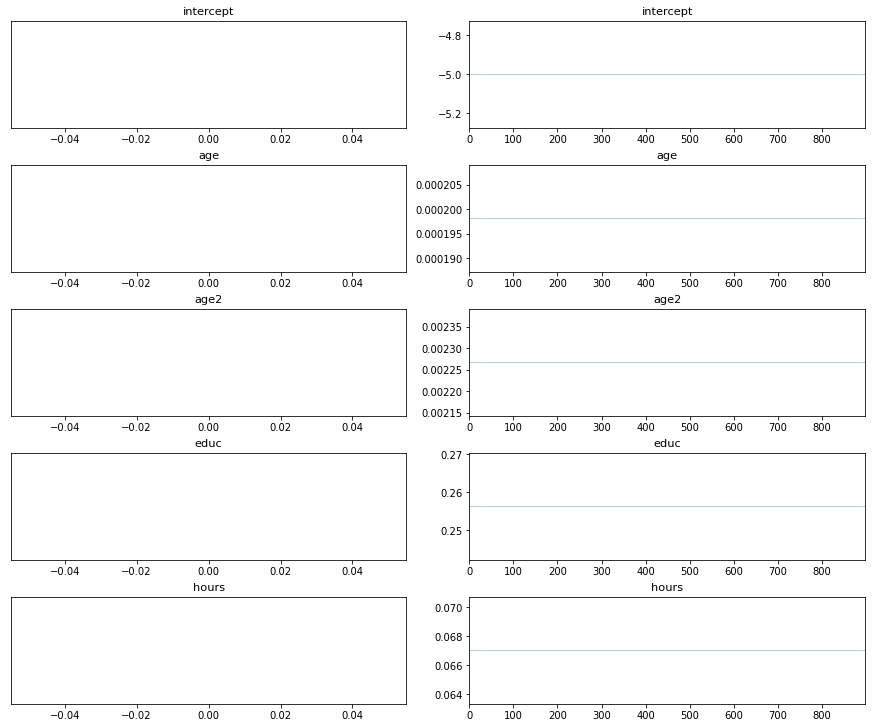

In [63]:
import arviz as az

aehmc_trace = az.from_dict(
    posterior={
        "intercept": position[BURNIN:, 0],
        "age": position[BURNIN:, 1],
        "age2": position[BURNIN:, 2],
        "educ": position[BURNIN:, 3],
        "hours": position[BURNIN:, 4],
    }
)
az.plot_trace(aehmc_trace);